# Pabrik Metallurgi Steel
oleh Luqmanulhakim

# Daftar Isi <a id='back'></a>

* [Pendahuluan](#intro)

* [Tahap 1. Ikhtisar Data](#data_review)
    * [1.1 Load data dan mendapatkan gambaran umum](#datarev_1)
    * [1.2 Menyiapkan fungsi](#datarev_2)
    
* [Tahap 2. Analisis](#analysis)
    * [2.1 Menganalisis Data](#analysis_1)
    * [2.1.1 Menganalisis data_arc](#analysis_1_1)
    * [2.1.2 Menganalisis data_bulk](#analysis_1_2)
    * [2.1.3 Menganalisis data_bulk_time](#analysis_1_3)
    * [2.1.4 Menganalisis data_gas](#analysis_1_4)
    * [2.1.5 Menganalisis data_temp](#analysis_1_5)
    * [2.1.6 Menganalisis data_wire](#analysis_1_6)
    * [2.1.7 Menganalisis data_wire_time](#analysis_1_7)
    * [2.2 Melakukan Agregasi Data](#analysis_2)

* [Tahap 3. Pengujian](#test)
    * [3.1 Train Test Split](#test_1)
    * [3.2 Menjalankan Model](#test_2)
    * [3.2.1 Linear Regression](#test_2_1)
    * [3.2.2 Decision Tree Regressor](#test_2_2)
    * [3.2.3 Random Forest Regressor](#test_2_3)
    * [3.2.4 XGBoost](#test_2_4)  
    * [3.3 Merangkum Hasil Pengujian Model](#test_3)
    * [3.4 Pengujian Model Terbaik](#test_4)
      
* [Temuan](#end)

* [Ikhtisar Project](#summary)

[Kembali ke Daftar Isi](#back)

# Pendahuluan <a id='intro'></a>

Pabrik metalurgi Steel memutuskan untuk mengurangi konsumsi listrik pada tahap pemrosesan baja. Peneliti harus membangun model yang memprediksi suhu baja.

### Tujuan:

Untuk mengoptimalkan biaya produksi dengan membangun model yang memprediksi suhu baja. Oleh karenanya kita perlu:
1. menyiapkan data
    - melakukan EDA
    - melewati proses
    - menghitung daya total
    - menghitung total waktu pemanasan
    - memeriksa fitur untuk multikolinearitas
    - membangun grafik dan distribusi untuk visualisasi data dan penentuan outlier statistik
    - menentukan frekuensi penggunaan material tertentu untuk paduan / alloying. Memotong yang jarang digunakan
    - menghapus batch yang tidak memiliki fitur target (suhu outlet)
    - membuat tabel tanda

2. melatih model:
    - Regresi linier
    - Pohon keputusan (regresi)
    - Hutan acak (regresi)
    - XGBoost
    - Jaringan saraf yang terhubung penuh.

Untuk semua model, direncanakan untuk menggunakan pemilihan parameter otomatis menggunakan GridSearchCV atau RandomizedSearchCV.

RANDOM_STATE akan ditetapkan ke "281122".

MAE akan digunakan sebagai metrik untuk memvalidasi model.

Kita membagi data menjadi dua sampel:
- pelatihan / training
- pengujian / test

Kita menggunakan sampel uji untuk menganalisis fitur dalam hal kepentingannya relatif terhadap fitur target untuk model terbaik.

### Tahapan:

Baja diproses dalam centong logam berkapasitas sekitar 100 ton. Agar centong dapat menahan suhu tinggi, centong dilapisi dengan batu bata tahan api dari dalam. Baja cair dituangkan ke dalam centong dan dipanaskan hingga suhu yang diinginkan dengan elektroda grafit. Elektroda tersebut dipasang di tutup ember.

Sulfur dihilangkan dari paduan (desulfurisasi), komposisi kimia dikoreksi dengan menambahkan pengotor, dan sampel diambil. Baja dicampur - komposisinya diubah - dengan memasukkan potongan paduan dari bunker untuk bahan curah atau kawat melalui peralatan khusus (bahasa Inggris "mass").

Sebelum memasukkan aditif paduan untuk pertama kalinya, suhu baja diukur dan analisis kimianya dilakukan. Kemudian suhu dinaikkan selama beberapa menit, bahan paduan ditambahkan, dan paduan dibersihkan dengan gas inert. Kemudian diaduk dan diukur lagi. Siklus ini diulang hingga komposisi kimia target dan suhu leleh optimal tercapai.

Kemudian baja cair dikirim untuk menyelesaikan logam atau memasuki mesin pengecoran kontinyu. Dari sana, produk jadi keluar dalam bentuk lempengan kosong (bahasa Inggris *slab*, “slab”).

### Deskripsi Data:

Data didapat dari Kaggle di alamat https://www.kaggle.com/datasets/yuriykatser/industrial-data-from-the-ladlefurnace-unit

Data terdiri dari beberapa file sebagai berikut:

- `data_arc.csv` — data elektroda
- `data_bulk.csv` — data terkait pasokan material curah (volume)
- `data_bulk_time.csv` — data terkait pasokan material curah (waktu)
- `data_gas.csv` — data terkait pembersihan gas paduan / alloy gas purge 
- `data_temp.csv` — data hasil pengukuran suhu
- `data_wire.csv` — data terkait material kawat (volume)
- `data_wire_time.csv` — data terkait material kawat (waktu).

Di semua berkas, kolom kunci berisi nomor batch.

Bisa terdapat beberapa baris dalam berkas dengan nilai kunci yang sama, baris-baris tersebut sesuai dengan iterasi pemrosesan yang berbeda.

Untuk keteraturan penempatan file dibuatkan folder bernama '**steel**' dalam folder datasets (**datasets/steel/**)

[Kembali ke Daftar Isi](#back)

# Tahap 1. Ikhtisar Data <a id='data_review'></a>

Melakukan import library yang diperlukan, membuka data terkait yang akan dievaluasi, kemudian menjelajahi data tersebut.

**Step 1.1**
Melakukan import libraries dan modules yang diperlukan. Untuk beberapa libraries yang tidak bisa diimpor sebelumnya telah dilakukan instalasi.

In [1]:
# import library untuk visualisasi grafik

from tabulate import tabulate
import pandas as pd
import numpy as np
import seaborn as sb
import math as m
import matplotlib.pyplot as plt

In [2]:
# import library untuk machine learning

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

## Load data dan mendapatkan gambaran umum <a name='datarev_1'></a>

**Step 1.2**
Melakukan load data yang diperlukan:
- dari file *data_arc.csv* untuk kemudian disimpan ke dalam dataframe data_arc
- dari file *data_bulk.csv* untuk kemudian disimpan ke dalam dataframe data_bulk
- dari file *data_bulk_time.csv* untuk kemudian disimpan ke dalam dataframe data_bulk_time
- dari file *data_gas.csv* untuk kemudian disimpan ke dalam dataframe data_gas
- dari file *data_temp.csv* untuk kemudian disimpan ke dalam dataframe data_temp
- dari file *data_wire.csv* untuk kemudian disimpan ke dalam dataframe data_wire
- dari file *data_wire_time.csv* untuk kemudian disimpan ke dalam dataframe data_wire_time

In [3]:
path = 'datasets/steel/'
data_arc = pd.read_csv(path + 'data_arc.csv')             # data elektroda
data_bulk = pd.read_csv(path + 'data_bulk.csv')           # data terkait pasokan material curah (volume)
data_bulk_time = pd.read_csv(path + 'data_bulk_time.csv') # data terkait pasokan material curah (waktu)
data_gas = pd.read_csv(path + 'data_gas.csv')             # data terkait pembersihan gas paduan / alloy gas purge
data_temp = pd.read_csv(path + 'data_temp.csv')           # data hasil pengukuran suhu
data_wire = pd.read_csv(path + 'data_wire.csv')           # data terkait material kawat (volume)
data_wire_time = pd.read_csv(path + 'data_wire_time.csv') # data terkait material kawat (waktu)

## Menyiapkan fungsi <a name='datarev_2'></a>

**Step 1.3**
Membuat fungsi yang mengambil kolom sebagai input dan mengembalikan batas whisker

In [4]:
# fungsi yang mengambil kolom sebagai input dan mengembalikan batas "whisker"
def det_whiskers(x):
    descr = x.describe()
    
    # jangkauan interkuartil
    iqr = descr[6] - descr[4]
       
    left_whisker = round(descr[4] - 1.5 * iqr, 2)
    right_whisker = round(descr[6] + 1.5 * iqr, 2)

    if left_whisker < descr[3]: left_whisker = descr[3] 
        
    if right_whisker > descr[7]: right_whisker = descr[7]
        
    return [left_whisker, right_whisker]


# fungsi untuk analisis data primer
def get_dataset_description(x):    
    display(x.info())
    display(x.describe())
    display(x.head())

    
# fungsi untuk memplot grafik penggunaan material curah dan kawat
def material_in_use(x):
    pers = ~x.isnull()
    bulk_use = {}
    for i in (pers.columns):
        if i == 'key':
            continue
        bulk_use[i] = pers[i].mean()
        
    sorted_dict_bulk = {}
    sorted_keys = sorted(bulk_use, key=bulk_use.get) 
    for w in sorted_keys:
        sorted_dict_bulk[w] = bulk_use[w]

        
    bad_data = []
    good_data = []
    for i in sorted_dict_bulk:
        if sorted_dict_bulk[i] < 0.1:
            bad_data.append(i)
        else:
            good_data.append(i)

    fig, ax = plt.subplots(figsize=(15,5))
    ax.bar(sorted_dict_bulk.keys() , sorted_dict_bulk.values(), width=1, edgecolor="white", linewidth=0.7)
    ax.axhline(y=0.1, color='red', linestyle='-')
    ax.set_title('Statistika penggunaan material')
    ax.set_ylabel('Persentase penggunaan dalam batch')
    ax.set_xlabel('Jenis material')
    print(f"Material yang jarang digunakan: {bad_data}" )
    print(f"Material yang umum digunakan: {good_data}" )
  
    
# fungsi untuk memplot grafik dengan urgensi fitur
def chart_feature_imp(model,train):
    feature_imp = pd.Series(model.feature_importances_, index=train.columns).sort_values(ascending=False)
    plt.figure(figsize=(15, 10))
    ax = sb.barplot(x=feature_imp, y=feature_imp.index)     
    ax.set_xlabel('Penilaian urgensi fitur', fontsize=18)
    ax.set_ylabel('Ciri', fontsize=18)
    ax.set_title('Visualisasi urgensi fitur', fontsize=20)
    ax.tick_params(axis = 'both', labelsize = 14)

[Kembali ke Daftar Isi](#back)

# Tahap 2. Analisis <a name='analysis'></a>

## Menganalisis Data <a name='analysis_1'></a>

### Menganalisis data_arc <a name='analysis_1_1'></a>

**Step 2.1**
Melakukan rangkaian analisis dataset data_arc

In [5]:
get_dataset_description(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   Heating start   14876 non-null  object 
 2   Heating end     14876 non-null  object 
 3   Active power    14876 non-null  float64
 4   Reactive power  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Active power,Reactive power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


,key,Heating start,Heating end,Active power,Reactive power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [6]:
# Nama fitur perlu diubah

data_arc.columns = ['key','strt_arc_heat','end_arc_heat','active_power','reactive_power']
# display(data_arc)

In [7]:
# perlu mengubah jenis fitur seperti 'strt_arc_heat' dan 'end_arc_heat'

data_arc['strt_arc_heat'] = pd.to_datetime(data_arc['strt_arc_heat'])
data_arc['end_arc_heat'] = pd.to_datetime(data_arc['end_arc_heat'])

Text(0.5, 0, 'Daya aktif')

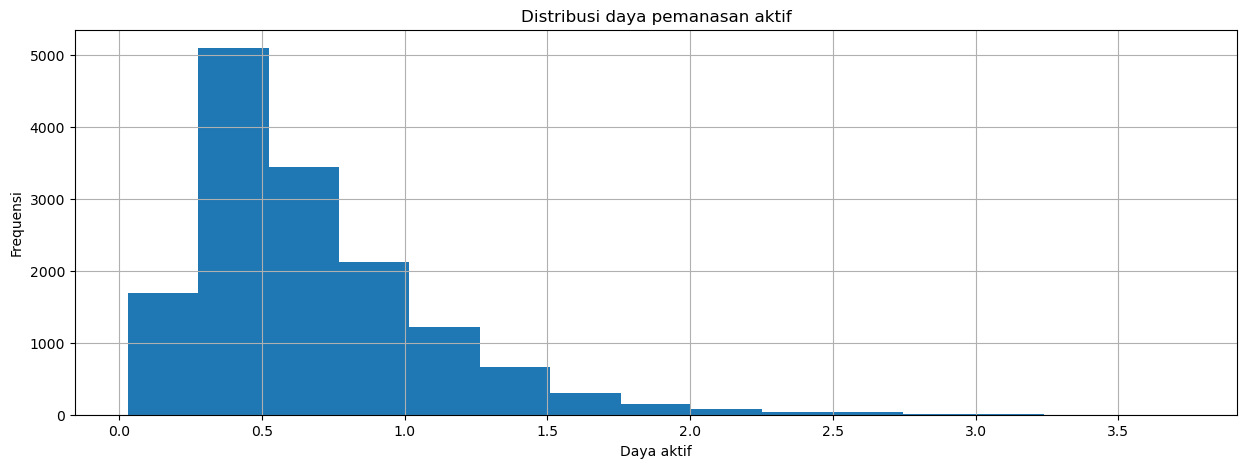

In [8]:
# histogram distribusi daya aktif
data_arc['active_power'].hist(bins=15,figsize=(15,5))
plt.title('Distribusi daya pemanasan aktif')
plt.ylabel('Frequensi')
plt.xlabel('Daya aktif')

Daya Aktif (P = U * I) adalah bagian daya yang berguna, bagian yang menentukan konversi langsung energi listrik menjadi jenis energi lain yang diperlukan. Daya aktif sebenarnya menentukan laju konsumsi energi yang berguna.

-------------------------------------------------- -----------------------------------------------------------------------------

Daya yang terus mengalir bolak-balik antara sumber dan beban dikenal sebagai Reaktif (Q). Daya reaktif adalah daya yang dikonsumsi dan kemudian dikembalikan oleh beban karena sifat reaktifnya. Daya reaktif biasanya "berbahaya" atau "menyimpang".

Dilihat dari grafik histogram, paling sering terdapat 5 iterasi pemanasan untuk satu batch.

Text(0.5, 0, 'Jumlah iterasi')

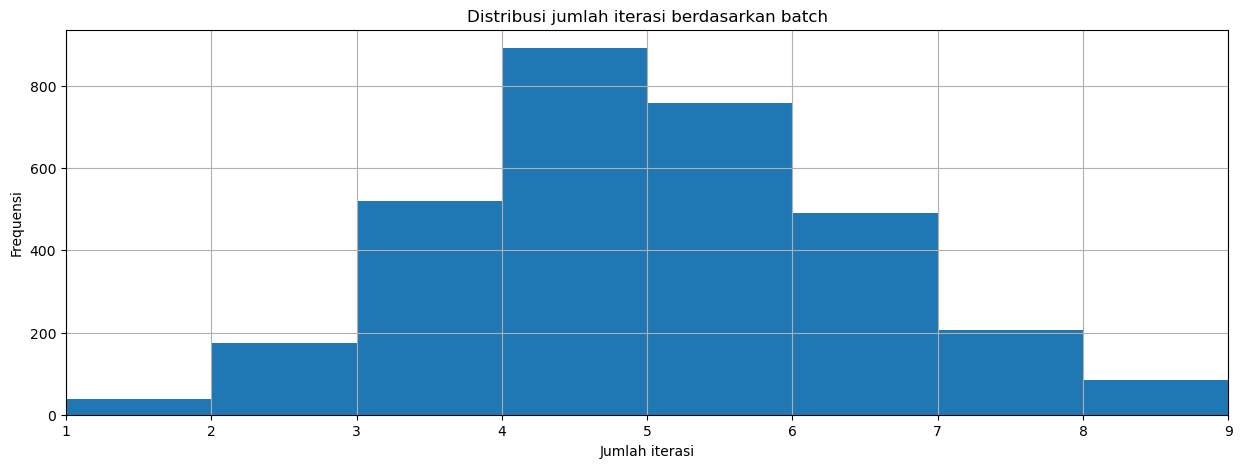

In [9]:
# Membuat plot histogram untuk distribusi jumlah iterasi berdasarkan batch
data_arc.groupby('key')['active_power'].count().hist(bins=15,figsize=(15,5))
plt.xlim(det_whiskers(data_arc.groupby('key')['active_power'].count()))
plt.title('Distribusi jumlah iterasi berdasarkan batch')
plt.ylabel('Frequensi')
plt.xlabel('Jumlah iterasi')

Dari ringkasan statistik dapat dilihat bahwa nilai minimum untuk karakteristik "reactive_power" adalah negatif.
Berdasarkan informasi yang diperoleh di domain publik, daya reaktif dapat menjadi negatif jika beban bersifat aktif-kapasitif. (Jika arus tertinggal di belakang tegangan, pergeseran fasa dianggap positif, jika lebih maju, maka negatif).

Mari kita periksa seberapa sering nilai negatif ditemukan dalam fitur 'reactive_power'. Untuk melakukan ini, fitur 'reactive_power' diurutkan dalam urutan menaik. Anda dapat melihat bahwa hanya ada satu nilai negatif dalam kumpulan data 'data_arc'. Mungkin lonjakan ini terbentuk selama penurunan tegangan yang tajam.

Agar tidak menghapus data seluruh kumpulan, kita akan membangun ketergantungan 'active_power' vs 'reactive_power' dan, dengan menggunakan persamaan garis trend, kita akan mendapatkan nilai baru, bukan nilai negatif.

In [10]:
# memeriksa jumlah nilai negatif
display(data_arc.sort_values(by='reactive_power', ascending=True).head(10))

# memeriksa nilai daya reaktif dalam batch dengan angka negatif
display(data_arc[data_arc['key'] == 2116])

,key,strt_arc_heat,end_arc_heat,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
5596,1216,2019-06-16 08:22:19,2019-06-16 08:22:30,0.030188,0.020806
2419,521,2019-05-22 17:42:57,2019-05-22 17:43:11,0.030563,0.021154
4914,1060,2019-06-11 04:31:57,2019-06-11 04:32:08,0.031630,0.022485
4633,1000,2019-06-09 01:17:44,2019-06-09 01:17:57,0.038186,0.022983
676,146,2019-05-08 19:18:55,2019-05-08 19:19:07,0.035400,0.023228
4063,873,2019-06-04 18:34:19,2019-06-04 18:34:30,0.040905,0.023569
6580,1432,2019-06-23 21:13:19,2019-06-23 21:13:34,0.034053,0.025329
8704,1892,2019-07-09 18:51:37,2019-07-09 18:51:50,0.038364,0.026079
4615,996,2019-06-08 22:06:27,2019-06-08 22:09:03,0.035165,0.026222


,key,strt_arc_heat,end_arc_heat,active_power,reactive_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


None


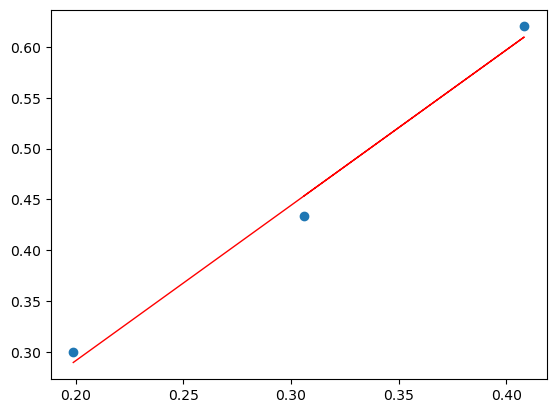

In [11]:
# 'active_power' vs 'reactive_power'
def plot_relationship(data):    
    x = data.query("key == 2116 and reactive_power > 0")['reactive_power'].to_list()
    y = data.query("key == 2116 and reactive_power > 0")['active_power'].to_list()

    #membuat scatterplot
    plt.scatter (x, y)

    #menghitung persamaan untuk garis trend
    z = np.polyfit (x, y, 1)
    p = np.poly1d (z)

    #menambahkan garis trend ke plot
    plt.plot (x, p(x), color="red", linewidth=1 , linestyle="-")
    
print(plot_relationship(data_arc))

None

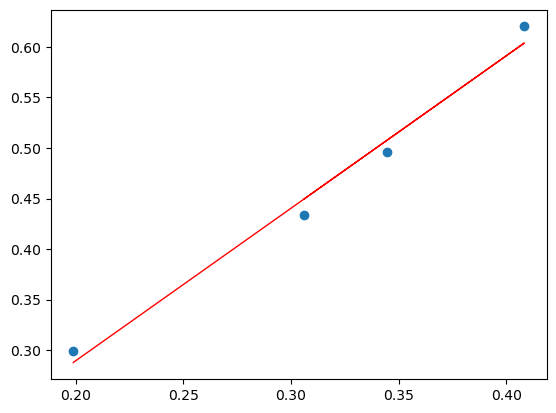

In [12]:
# hubungan ini dijelaskan lebih baik dengan fungsi logaritma f(x)=0.2861*ln(x) + 0.5438

data_arc.at[9780, 'reactive_power'] = 0.2877 * m.log(0.496) + 0.5461
display(plot_relationship(data_arc))

<Figure size 640x480 with 0 Axes>

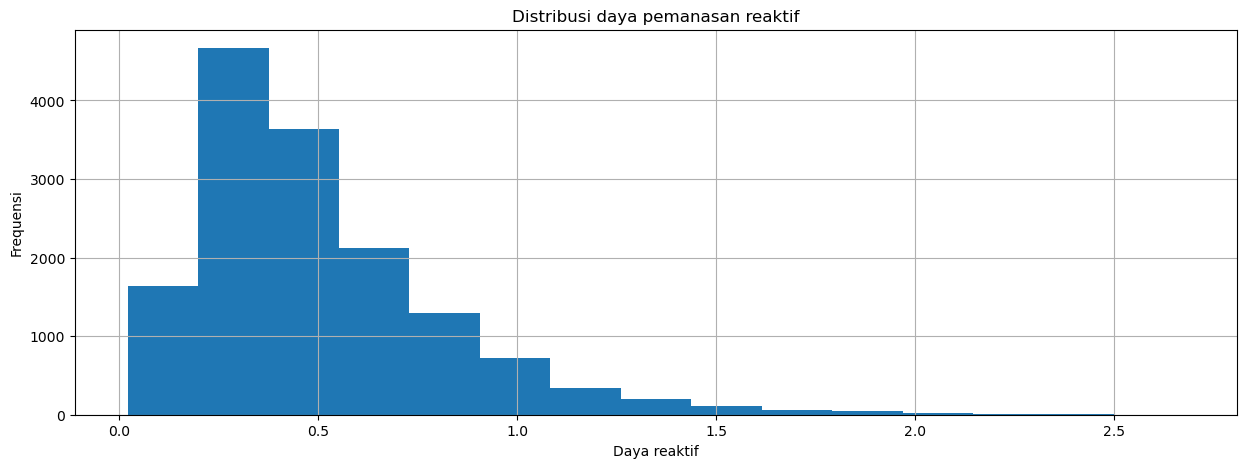

<Figure size 640x480 with 0 Axes>

In [13]:
# histogram Distribusi daya pemanasan reaktif
data_arc['reactive_power'].hist(bins=15,figsize=(15,5))
plt.title('Distribusi daya pemanasan reaktif')
plt.ylabel('Frequensi')
plt.xlabel('Daya reaktif')
plt.figure()

"Data_arc" telah dipelajari dan diproses:
- tidak ditemukan celah / gap data
- nama kolom telah diganti nama
- satu nilai negatif ditemukan di kolom 'reactive_power'. Nilai tersebut dihitung dari hubungan 'reactive_power' vs 'active_power'

Selanjutnya, kita perlu menemukan:
- total waktu pemanasan;
- jumlah pemanasan dimulai;
- total daya aktif dan reaktif;
- daya penuh di setiap batch.

In [14]:
# Untuk setiap batch kita menemukan total daya aktif dan reaktif
pivot_arc = data_arc.pivot_table(index='key', values=['active_power', 'reactive_power'], aggfunc='sum')
# pivot_arc

In [15]:
# Waktu pemanasan elektroda di setiap iterasi
data_arc['heat_time'] = data_arc['end_arc_heat'] - data_arc['strt_arc_heat']

# Untuk setiap batch kita menemukan total waktu pemanasan
pivot_arc['heat_time'] = data_arc.groupby('key')['heat_time'].sum()
# pivot_arc.head()

# Mengubah waktu pemanasan menjadi detik
def seconds(row):
    return row.total_seconds()
pivot_arc['heat_time'] = pivot_arc['heat_time'].apply(seconds)
# pivot_arc.head()

# Daya penuh untuk setiap batch
pivot_arc['full_power'] = ((pivot_arc['active_power']) ** 2 + (pivot_arc['reactive_power']) ** 2) ** 0.5
display(pivot_arc)

,active_power,reactive_power,heat_time,full_power
key,,,,
1,4.878147,3.183241,1098.0,5.824889
2,3.052598,1.998112,811.0,3.648398
3,2.525882,1.599076,655.0,2.989502
4,3.209250,2.060298,741.0,3.813674
5,3.347173,2.252643,869.0,4.034596
...,...,...,...,...
3237,3.932467,2.828459,909.0,4.844014
3238,2.106529,1.681182,546.0,2.695151
3239,4.666754,3.111617,1216.0,5.608989


In [16]:
pivot_arc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3214 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   active_power    3214 non-null   float64
 1   reactive_power  3214 non-null   float64
 2   heat_time       3214 non-null   float64
 3   full_power      3214 non-null   float64
dtypes: float64(4)
memory usage: 125.5 KB


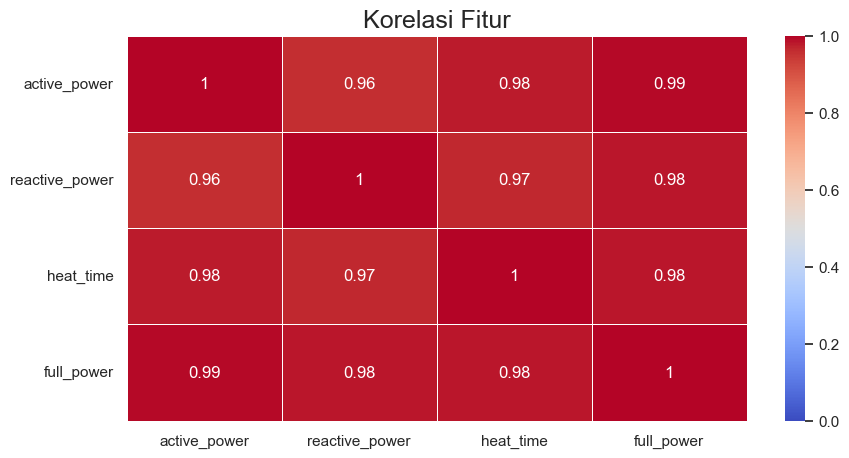

In [17]:
pivot_arc_corr = pivot_arc.corr(numeric_only=True)
sb.set_theme()
f,ax=plt.subplots(figsize=(10,5))
sb.heatmap(pivot_arc_corr, annot=True, linewidths=.5,vmin=0.0, vmax=1, cmap='coolwarm')
plt.title("Korelasi Fitur", fontsize=18)
plt.show()

Selanjutnya dalam pekerjaan ini, kita akan menggunakan tabel "pivot_arc" untuk menggabungkan dan melatih model.
Tabel ini akan mencakup:
- daya aktif;
- daya reaktif;
- waktu pemanasan dalam hitungan detik;
- daya penuh.

Pada tahap akhir pemrosesan data, beberapa fitur ini dapat dikecualikan untuk mencegah multikolinier. Seperti yang dapat dilihat dari matriks korelasi, semua parameter dalam kumpulan data "pivot_arc" sangat berkorelasi satu sama lain.

#### Skala Chaddock sebagai rujukan
```
+--------------------------------------+---------------------------+
| Absolute Value of Correlation, ( R ) |       Interpretation      |
+======================================+===========================+
|             0,00 - 0,30              |   Negligible correlation  |
+--------------------------------------+---------------------------+
|             0,30 - 0,50              |      Weak correlation     |
+--------------------------------------+---------------------------+
|             0,50 - 0,70              |    Moderate correlation   |
+--------------------------------------+---------------------------+
|             0,70 - 0,90              |     Strong correlation    |
+--------------------------------------+---------------------------+
|             0,70 - 0,90              |  Very strong correlation  |
+--------------------------------------+---------------------------+
```

### Menganalisis data_bulk <a name='analysis_1_2'></a>

**Step 2.2**
Melakukan rangkaian analisis dataset data_bulk (bulk material feed data (volume))

In [18]:
get_dataset_description(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Struktur tabel "data_bulk_time" dan "data_bulk" sama. Hal ini juga berlaku untuk tabel data kawat.
Kelalaian menunjukkan bahwa material tersebut tidak digunakan dalam proses produksi beberapa batch.
Ada banyak material dalam tabel tentang material curah "data_bulk" dan tentang kawat "data_wire" yang jarang digunakan.
Kita akan memasukkan ke dalam model hanya data yang celahnya tidak lebih dari 90% dari total panjang kumpulan data.
Dengan demikian, berikut ini akan dimasukkan ke dalam model: 6,4,3,15,12,14 material curah.

Material yang jarang digunakan: ['Bulk 8', 'Bulk 13', 'Bulk 9', 'Bulk 2', 'Bulk 7', 'Bulk 5', 'Bulk 10', 'Bulk 11', 'Bulk 1']
Material yang umum digunakan: ['Bulk 6', 'Bulk 4', 'Bulk 3', 'Bulk 15', 'Bulk 12', 'Bulk 14']


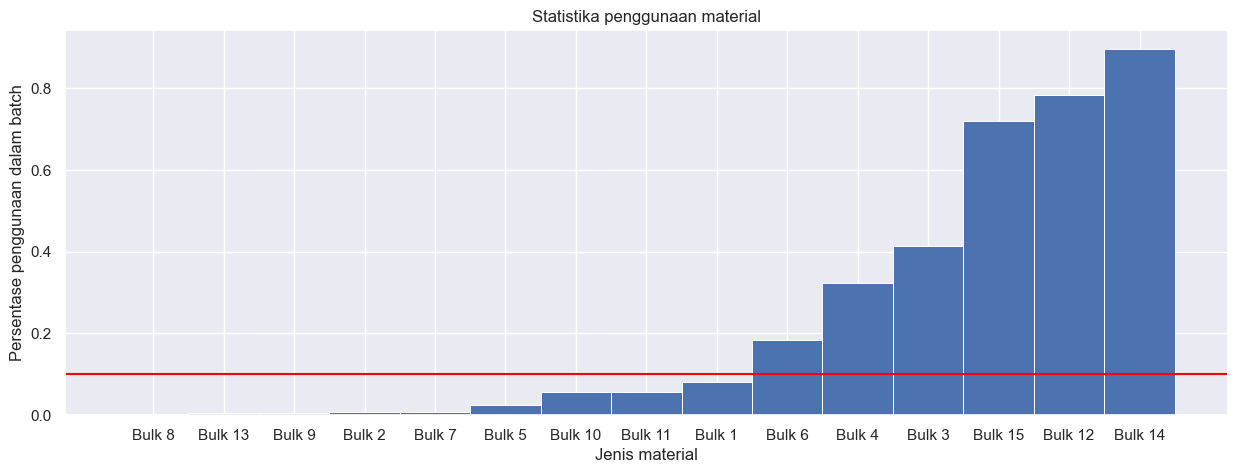

In [19]:
# Menggunakan fitur untuk mendeteksi material yang jarang digunakan
material_in_use(data_bulk)

In [20]:
# Nama fitur yang perlu diubah
data_bulk.columns = ['key','Bulk_1','Bulk_2','Bulk_3','Bulk_4','Bulk_5','Bulk_6','Bulk_7','Bulk_8'\
                     ,'Bulk_9','Bulk_10','Bulk_11',\
                     'Bulk_12','Bulk_13','Bulk_14','Bulk_15']

In [21]:
# Nan yang tersisa akan digantikan dengan nilai nol. Kita akan berasumsi bahwa pada suatu titik waktu tertentu, Nan tidak digunakan.
data_bulk = data_bulk.fillna(0)

In [22]:
# Menghapus hapus material yang jarang digunakan dari kumpulan data / dataset
data_bulk = data_bulk.drop(columns = ['Bulk_8','Bulk_13','Bulk_9','Bulk_2','Bulk_7','Bulk_5','Bulk_10','Bulk_11','Bulk_1'],axis = 1)

In [23]:
# Menemukan jumlah semua material untuk batch tertentu
# data_bulk['sum_bulk'] = data_bulk[['Bulk_6', 'Bulk_4', 'Bulk_3', 'Bulk_15', 'Bulk_12', 'Bulk_14']].sum(axis=1)

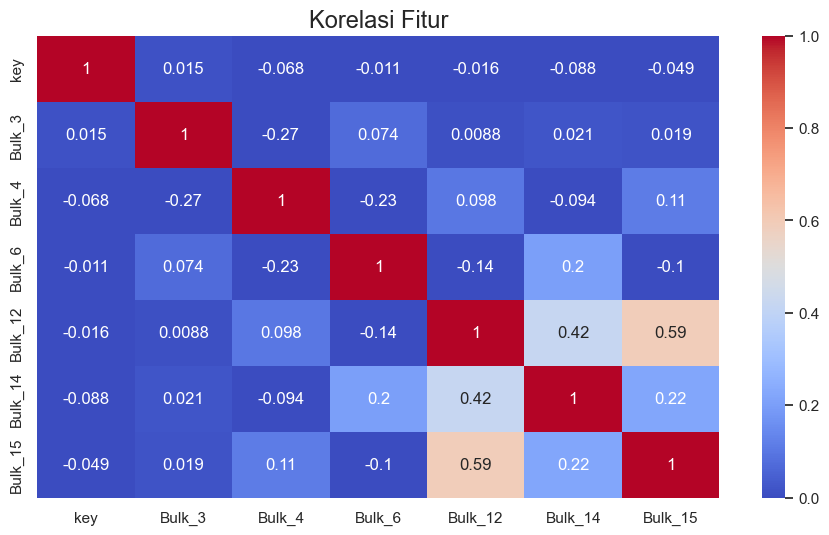

In [24]:
data_bulk_corr = data_bulk.corr(numeric_only=True)
f,ax=plt.subplots(figsize=(11,6))
sb.heatmap(data_bulk_corr, annot=True,vmin=0, vmax=1, cmap='coolwarm')
plt.title("Korelasi Fitur", fontsize=17)
plt.show()

Mari kita ambil contoh berikut untuk melatih model:
- Bulk 6
- Bulk 4
- Bulk 3
- Bulk 15
- Bulk 12
- Bulk 14

Multikolinieritas antara fitur material massal / bulk tidak ditemukan.

### Menganalisis data_bulk_time  <a name='analysis_1_3'></a>

**Step 2.3**
Melakukan rangkaian analisis dataset data_bulk_time (bulk material feed data (time))

Karena kita perlu memecahkan masalah yang bukan tentang deret waktu, faktor waktu tidak akan dilibatkan dalam pelatihan model.

In [25]:
get_dataset_description(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [26]:
# Nama fitur yang perlu diubah

data_bulk_time.columns = ['key','Bulk_1','Bulk_2','Bulk_3','Bulk_4','Bulk_5','Bulk_6','Bulk_7','Bulk_8'\
                     ,'Bulk_9','Bulk_10','Bulk_11',\
                     'Bulk_12','Bulk_13','Bulk_14','Bulk_15']
# display(data_bulk_time)

In [27]:
# Menghapus bahan yang jarang digunakan dari kumpulan data / dataset
data_bulk_time = data_bulk_time.drop(columns = ['Bulk_8','Bulk_13','Bulk_9','Bulk_2','Bulk_7','Bulk_5','Bulk_10','Bulk_11','Bulk_1'],axis = 1)

### Menganalisis data_gas <a name='analysis_1_4'></a>

**Step 2.4**
Melakukan rangkaian analisis dataset data_gas (alloy gas purge data)

In [28]:
get_dataset_description(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Gas 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Gas 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,key,Gas 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [29]:
# Nama fitur yang perlu diubah

data_gas.columns = ['key','gas']
# display(data_gas)

(0.0083985291, 23.86)

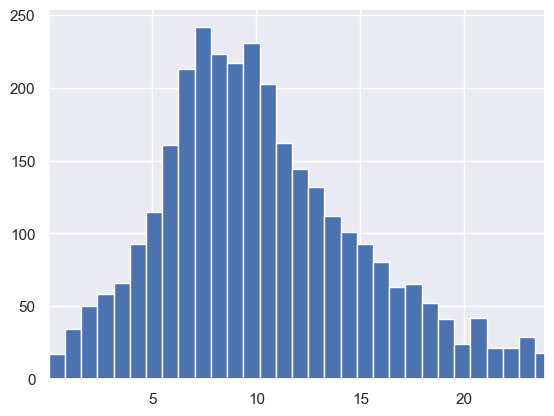

In [30]:
data_gas['gas'].hist(bins=100)
plt.xlim(det_whiskers(data_gas['gas']))

Menghapus penggantian outlier dengan median dalam data gas. Tidak ditemukan celah / gap dalam data ini sehingga kita menggunakannya secara keseluruhan.

### Menganalisis data_temp  <a name='analysis_1_5'></a>

**Step 2.5**
Melakukan rangkaian analisis dataset data_temp (temperature measurement results)

In [31]:
get_dataset_description(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   time         15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


,key,time,Temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Dengan memeriksa distribusinya, dapat dilihat bahwa data memiliki dispersi yang kecil. Oleh karena itu, untuk paduan kami, suhu berubah dalam batas yang kecil. Kita dapat menyimpulkan bahwa outlier juga dapat digantikan oleh median. Memilih median karena tidak terpengaruh oleh outlier.

In [32]:
# Nama fitur yang perlu diubah

data_temp.columns = ['key','measure_time','temperature']
# display(data_temp)

<Axes: >

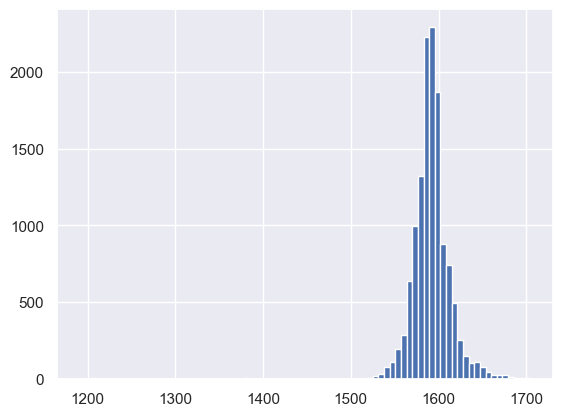

In [33]:
data_temp['temperature'].hist(bins=80)

(1551.0, 1631.0)

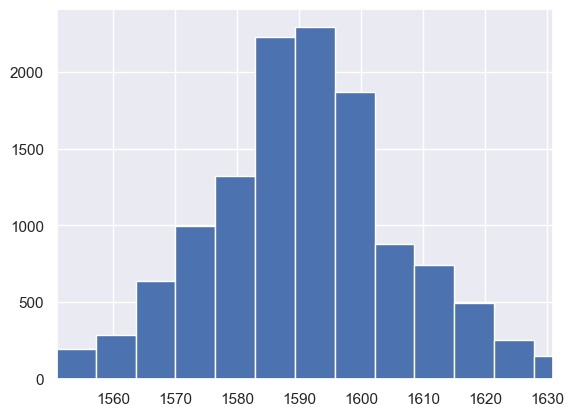

In [34]:
data_temp['temperature'].hist(bins=80)
plt.xlim(det_whiskers(data_temp['temperature']))

In [35]:
data_temp[data_temp['temperature'] < 1300] = data_temp['temperature'].median()

Selanjutnya, suhu batch terakhir yang diukur harus dipilih sebagai fitur target. Jika tidak ada suhu seperti itu, kita harus menghapus data seluruh lot karena suhu tersebut adalah fitur target. Suhu batch pertama dapat digunakan sebagai salah satu fitur.
Pengukuran suhu antara / intermediate tidak direncanakan untuk digunakan dalam model.

In [36]:
# Mengganti semua nilai suhu yang hilang dengan nol lalu menghapus nilai semua batch di mana suhu = 0
data_temp = data_temp.fillna(value=0)

In [37]:
# Mengambil waktu pengukuran suhu pertama untuk setiap batch
first_temp = data_temp.pivot_table(index='key',values=['measure_time', 'temperature'], aggfunc='first')

In [38]:
# Mengambil waktu pengukuran suhu terbaru untuk setiap batch
last_temp = data_temp.pivot_table(index='key',values=['measure_time', 'temperature'], aggfunc='last')

In [39]:
# Kita menggabungkan data “first_temp” dan “last_temp” dengan kunci / key batch
overall_temp = first_temp.merge(last_temp, left_on='key',right_on='key')
overall_temp.columns = ['first_time','first_temp', 'last_time', 'last_temp']
# overall_temp

In [40]:
overall_temp

,first_time,first_temp,last_time,last_temp
key,,,,
1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
...,...,...,...,...
3237,2019-08-31 22:44:04,1569.0,2019-08-31 23:05:43,0.0
3238,2019-08-31 23:30:31,1584.0,2019-08-31 23:43:00,0.0
3239,2019-09-01 01:31:47,1598.0,2019-09-01 02:24:15,0.0


### Menganalisis data_wire  <a name='analysis_1_6'></a>

**Step 2.6**
Melakukan rangkaian analisis dataset data_wire (wire materials data (volume))

In [41]:
get_dataset_description(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Terdapat banyak material dalam tabel tentang material curah "data_bulk" dan tentang kawat "data_wire" yang jarang digunakan.
Kami akan memasukkan ke dalam model hanya data yang celahnya tidak lebih dari 90% dari total panjang dataset.
Jadi, berikut ini akan dimasukkan ke dalam model: 2 dan 1 material kawat untuk paduan / alloying.

Material yang jarang digunakan: ['Wire 5', 'Wire 7', 'Wire 4', 'Wire 8', 'Wire 9', 'Wire 3', 'Wire 6']
Material yang umum digunakan: ['Wire 2', 'Wire 1']


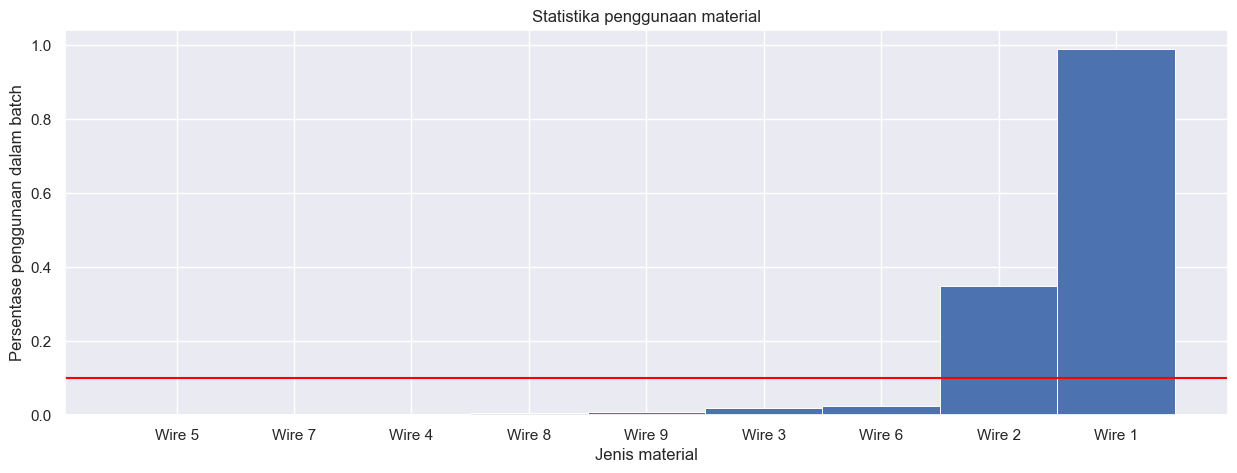

In [42]:
material_in_use(data_wire)

In [43]:
# Nama fitur yang perlu diubah

data_wire.columns = ['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']
# display(data_wire)

In [44]:
# Mengisi celah / gap dengan angka nol
data_wire = data_wire.fillna(0)

In [45]:
# Menghapus material yang jarang digunakan dari dataset
data_wire = data_wire.drop(columns = ['wire_5', 'wire_7', 'wire_4', 'wire_8', 'wire_9', 'wire_3', 'wire_6'], axis = 1)

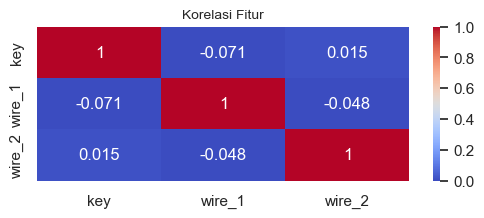

In [46]:
data_wire_corr = data_wire.corr(numeric_only=True)
f,ax=plt.subplots(figsize=(6,2))
sb.heatmap(data_wire_corr, annot=True, vmin=0, vmax=1, cmap='coolwarm')
plt.title("Korelasi Fitur", fontsize=10)
plt.show()

Mari kita ambil contoh untuk melatih model:
- Wire 1
- Wire 2

Tidak ditemukan multikolinearitas dalam data

### Menganalisis data_wire_time <a name='analysis_1_7'></a>

**Step 2.7**
Melakukan rangkaian analisis dataset data_wire_time (wire materials data (time))

In [47]:
get_dataset_description(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 72.3 KB


None

,key,wire_1,wire_2
count,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733
std,932.996726,42.841120,33.517734
min,1.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000
50%,1619.000000,100.114563,0.000000
75%,2434.000000,125.798405,23.162880
max,3241.000000,330.314424,282.780152


,key,wire_1,wire_2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


In [48]:
# Nama fitur yang perlu diubah

data_wire_time.columns = ['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']
# display(data_wire_time)

In [49]:
# Menghapus material yang jarang digunakan dari dataset
data_wire_time = data_wire_time.drop(columns = ['wire_5', 'wire_7', 'wire_4', 'wire_8', 'wire_9', 'wire_3', 'wire_6'],axis = 1)

In [50]:
# Menghubungkan dataframe nilai dan waktu
data_wire_overall = data_wire.merge(data_wire_time, left_on='key', right_on='key')

In [51]:
# Membuat tabel untuk pelatihan dengan bahan paduan / alloying materials
material_alloyage = data_bulk.merge(data_wire, left_on='key', right_on='key')
material_alloyage = material_alloyage.set_index('key')
material_alloyage

,Bulk_3,Bulk_4,Bulk_6,Bulk_12,Bulk_14,Bulk_15,wire_1,wire_2
key,,,,,,,,
1,0.0,43.0,0.0,206.0,150.0,154.0,60.059998,0.00000
2,0.0,73.0,0.0,206.0,149.0,154.0,96.052315,0.00000
3,0.0,34.0,0.0,205.0,152.0,153.0,91.160157,0.00000
4,0.0,81.0,0.0,207.0,153.0,154.0,89.063515,0.00000
5,0.0,78.0,0.0,203.0,151.0,152.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...
3237,170.0,0.0,0.0,252.0,130.0,206.0,38.088959,0.00000
3238,126.0,0.0,0.0,254.0,108.0,106.0,56.128799,0.00000
3239,0.0,0.0,114.0,158.0,270.0,88.0,143.357761,0.00000


## Melakukan Agregasi Data <a name='analysis_2'></a>

Empat dataframe disiapkan untuk pelatihan model. Kerangka-kerangka tersebut perlu digabungkan. Kita akan menggabungkan / merge  sesuai dengan kunci batch.

**Step 2.8**
Menggabungkan data

In [52]:
# Menggabungkan 4 tabel. Tabel utama untuk pelatihan akan menjadi "data"

data_1 = pivot_arc.merge(overall_temp, left_on='key', right_on='key')
data_2 = material_alloyage.merge(data_gas, left_on='key', right_on='key')
data = data_1.merge(data_2, left_on='key', right_on='key')

Fungsi target kita adalah suhu keluaran.
Kita perlu membuang batch yang suhu keluarannya nol.

**Step 2.9**
Melakukan analisis korelasi

In [53]:
# Mwnghapus batch yang suhu keluarannya nol.
data = data.query('last_temp != 0')

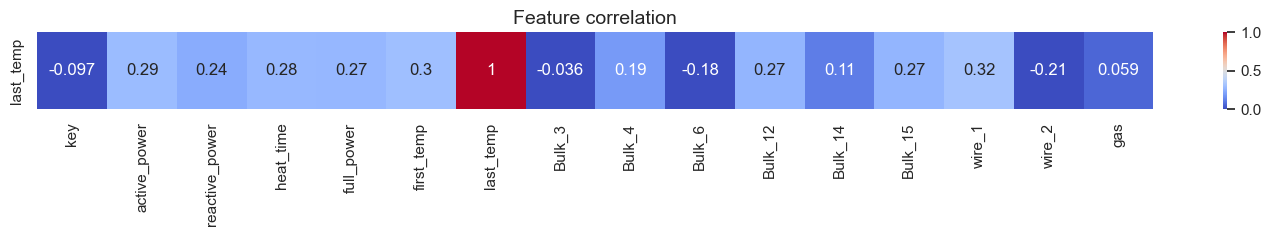

In [54]:
data_corr = data.corr(numeric_only=True)
f,ax=plt.subplots(figsize=(18,1))
sb.heatmap(data_corr.sort_values(by='last_temp', ascending=False).head(1), annot=True, vmin=0, vmax=1, cmap='coolwarm')
plt.title("Feature correlation", fontsize=14)
plt.show()

Tiga sifat berkorelasi dengan suhu keluaran dengan cara yang hampir sama, meskipun sifatnya serupa:
- daya reaktif / reactive_power
- daya aktif / active_power
- daya penuh / full_power

Mari kita tinggalkan yang paling berkorelasi - active_power. Kita akan menghapus sisanya.

Kita juga akan memeriksa tabel umum untuk multikolinearitas. Dapat dilihat bahwa ada fitur yang berkorelasi kuat "active_power", "heat_time", "reactive_power", "full_power". Kita tinggalkan saja "active_power" karena berkorelasi paling baik dengan parameter target.

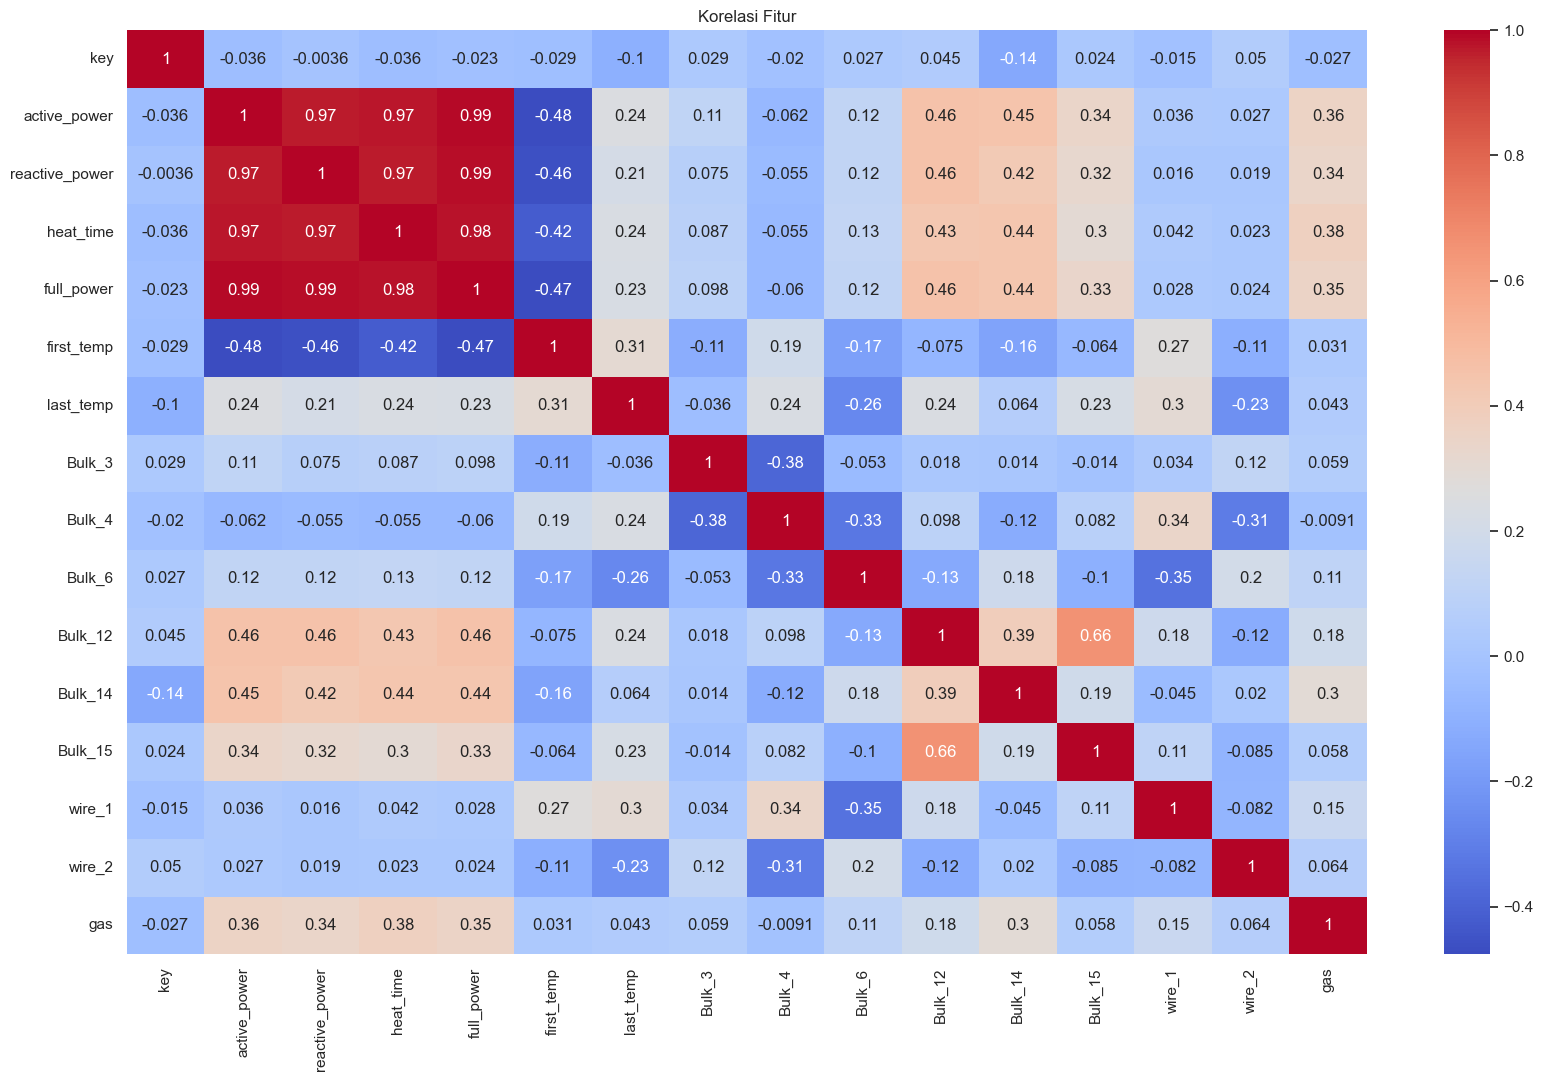

In [55]:
plt.figure(figsize=(20, 12))
plt.title('Korelasi Fitur')
sb.heatmap(data.corr(method='spearman',numeric_only=True), annot = True, cmap="coolwarm")
plt.show()

In [56]:
data = data.drop(columns = ['reactive_power','full_power','first_time','last_time','key','heat_time'])
data = data.reset_index(drop=True)

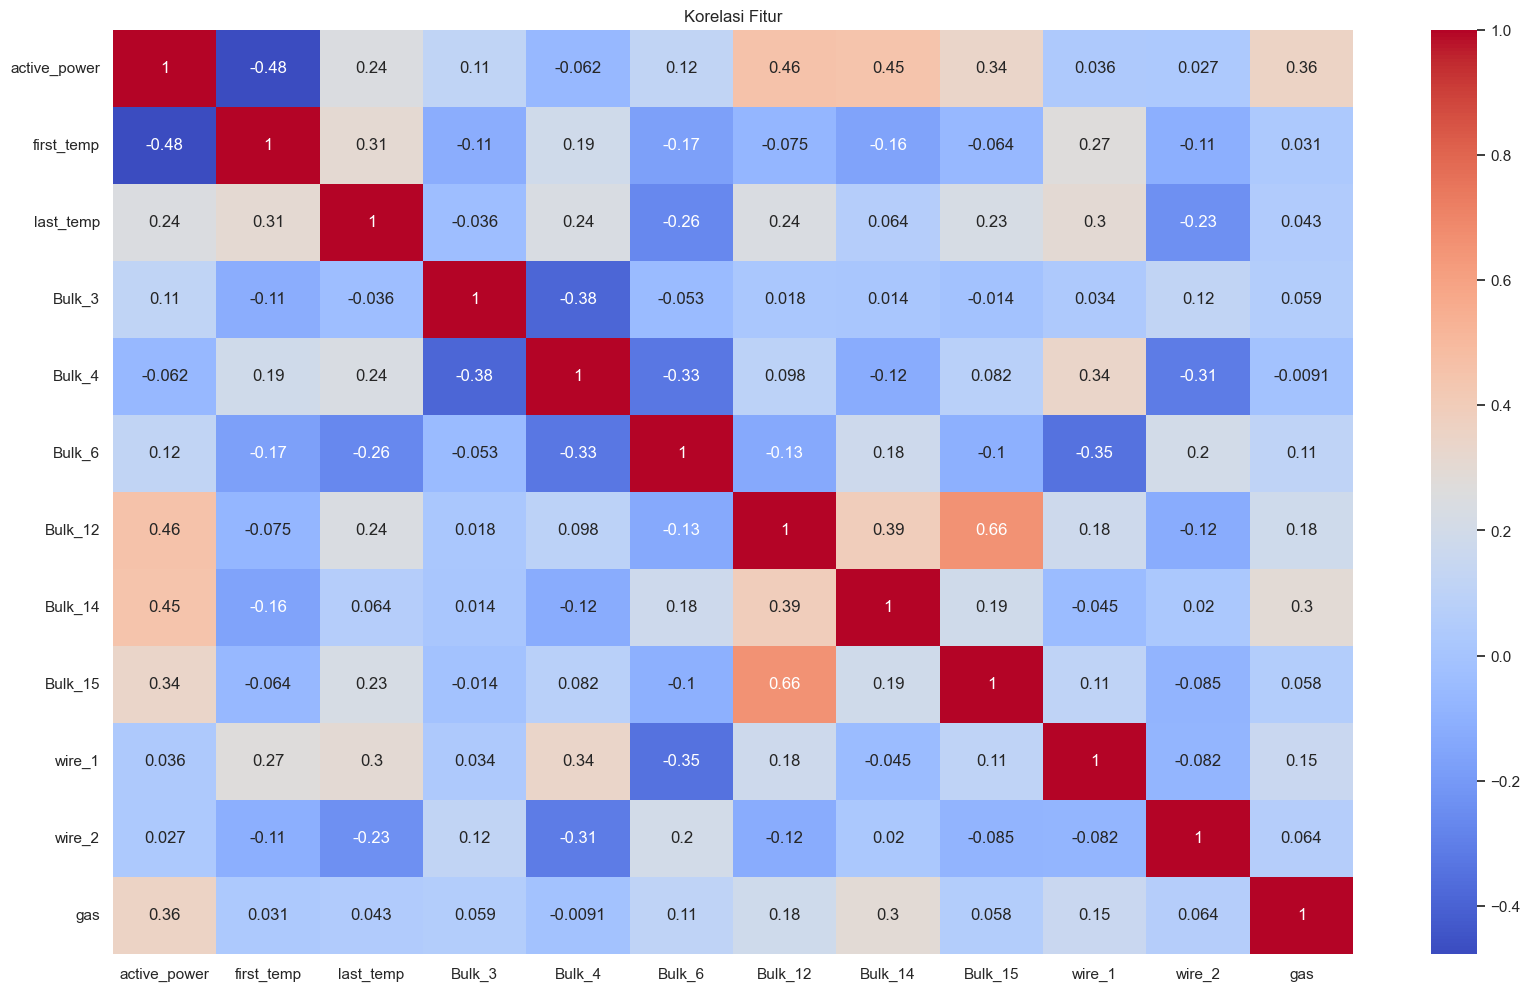

In [57]:
plt.figure(figsize=(20, 12))
plt.title('Korelasi Fitur')
sb.heatmap(data.corr(method='spearman',numeric_only=True), annot = True, cmap="coolwarm")
plt.show()

**Step 2.10**
Mendapatkan deskripsi data

In [58]:
get_dataset_description(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   active_power  2329 non-null   float64
 1   first_temp    2329 non-null   float64
 2   last_temp     2329 non-null   float64
 3   Bulk_3        2329 non-null   float64
 4   Bulk_4        2329 non-null   float64
 5   Bulk_6        2329 non-null   float64
 6   Bulk_12       2329 non-null   float64
 7   Bulk_14       2329 non-null   float64
 8   Bulk_15       2329 non-null   float64
 9   wire_1        2329 non-null   float64
 10  wire_2        2329 non-null   float64
 11  gas           2329 non-null   float64
dtypes: float64(12)
memory usage: 218.5 KB


None

,active_power,first_temp,last_temp,Bulk_3,Bulk_4,Bulk_6,Bulk_12,Bulk_14,Bulk_15,wire_1,wire_2,gas
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,3.152449,1587.388579,1593.363246,47.348218,37.303564,22.430228,208.415629,153.853585,119.952769,102.443601,17.609859,11.375600
std,1.425290,23.619908,11.200889,75.310430,58.643238,55.790873,157.062272,81.404354,84.640443,43.539993,33.624771,6.392041
min,0.186226,1519.000000,1541.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399
25%,2.173277,1571.000000,1587.000000,0.000000,0.000000,0.000000,105.000000,105.000000,0.000000,73.207679,0.000000,7.282948
50%,3.028334,1587.000000,1593.000000,0.000000,0.000000,0.000000,206.000000,149.000000,107.000000,101.119201,0.000000,10.100950
75%,3.920676,1603.000000,1598.000000,80.000000,77.000000,0.000000,282.000000,204.000000,204.000000,128.091599,23.102560,14.216688
max,17.496497,1660.000000,1653.000000,454.000000,281.000000,503.000000,1849.000000,636.000000,405.000000,330.314424,282.780152,77.995040


,active_power,first_temp,last_temp,Bulk_3,Bulk_4,Bulk_6,Bulk_12,Bulk_14,Bulk_15,wire_1,wire_2,gas
0,4.878147,1571.0,1613.0,0.0,43.0,0.0,206.0,150.0,154.0,60.059998,0.00000,29.749986
1,3.052598,1581.0,1602.0,0.0,73.0,0.0,206.0,149.0,154.0,96.052315,0.00000,12.555561
2,2.525882,1596.0,1599.0,0.0,34.0,0.0,205.0,152.0,153.0,91.160157,0.00000,28.554793
3,3.209250,1601.0,1625.0,0.0,81.0,0.0,207.0,153.0,154.0,89.063515,0.00000,18.841219
4,3.347173,1576.0,1602.0,0.0,78.0,0.0,203.0,151.0,152.0,89.238236,9.11456,5.413692


In [59]:
data

,active_power,first_temp,last_temp,Bulk_3,Bulk_4,Bulk_6,Bulk_12,Bulk_14,Bulk_15,wire_1,wire_2,gas
0,4.878147,1571.0,1613.0,0.0,43.0,0.0,206.0,150.0,154.0,60.059998,0.00000,29.749986
1,3.052598,1581.0,1602.0,0.0,73.0,0.0,206.0,149.0,154.0,96.052315,0.00000,12.555561
2,2.525882,1596.0,1599.0,0.0,34.0,0.0,205.0,152.0,153.0,91.160157,0.00000,28.554793
3,3.209250,1601.0,1625.0,0.0,81.0,0.0,207.0,153.0,154.0,89.063515,0.00000,18.841219
4,3.347173,1576.0,1602.0,0.0,78.0,0.0,203.0,151.0,152.0,89.238236,9.11456,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...
2324,3.210690,1570.0,1591.0,21.0,0.0,0.0,256.0,129.0,223.0,89.150879,0.00000,7.125735
2325,4.203064,1554.0,1591.0,0.0,63.0,0.0,256.0,129.0,226.0,114.179527,0.00000,9.412616
2326,2.212379,1571.0,1589.0,0.0,85.0,0.0,230.0,124.0,226.0,94.086723,9.04800,6.271699
2327,3.408725,1591.0,1594.0,90.0,0.0,0.0,206.0,129.0,207.0,118.110717,0.00000,14.953657


[Kembali ke Daftar Isi](#back)

# Tahap 3. Pengujian <a name="test"></a>

**Step 3.1**
Memilih fitur variabel dan fitur yang akan diprediksi untuk setiap tabel

## Train Test Split <a name="test_1"></a>

In [60]:
# Mari kita pilih fitur variabel dan fitur yang akan diprediksi untuk setiap tabel
features = data.drop('last_temp', axis=1)
target = data['last_temp']

# Memisahkan set validasi (30%) dari data asli
X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.3, random_state=281122)

## Menjalankan Model <a name="test_2"></a>

### Linear Regression <a name="test_2_1"></a>

Pertama kita skalakan data dalam hal deviasi standar untuk regresi linier karena terdapat perbedaan dimensionalitas

In [61]:
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)

In [62]:
%%time

model_linear_scaler = None
model_linear_scaler = LinearRegression()
model_linear_scaler.fit(X_train_scaler, y_train)
mae_linear_scaler1 = ms.cross_val_score(model_linear_scaler, X_train_scaler, y_train, scoring='neg_mean_absolute_error', cv=5)
mae_linear_scaler = -np.mean(mae_linear_scaler1)
print("Rata-rata MAE regresi linier pada set pelatihan dengan cross-validation: ",mae_linear_scaler)
print('-----------------------------------------------------------------------------------------------------------------')


Rata-rata MAE regresi linier pada set pelatihan dengan cross-validation:  6.287533141995132
-----------------------------------------------------------------------------------------------------------------
CPU times: total: 15.6 ms
Wall time: 13 ms


In [63]:
%%time

model_linear = None
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
mae_linear = ms.cross_val_score(model_linear, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
mae_linear = -np.mean(mae_linear)
print("Rata-rata MAE regresi linier pada set pelatihan dengan cross-validation: ",mae_linear)
print('-----------------------------------------------------------------------------------------------------------------')


Rata-rata MAE regresi linier pada set pelatihan dengan cross-validation:  6.287533141995128
-----------------------------------------------------------------------------------------------------------------
CPU times: total: 62.5 ms
Wall time: 22 ms


### Decision Tree Regressor <a name="test_2_2"></a>

In [64]:
%%time

model_tree = None
parametrs = {'max_depth': range(1,15,2)}
model_tree = DecisionTreeRegressor(random_state=281122)

tree = GridSearchCV(model_tree, parametrs, scoring='neg_mean_absolute_error', cv=10, n_jobs = -1)
tree.fit(X_train, y_train)
MAE_tree = -tree.best_score_ 
print("Opsi parameter terbaik: ",tree.best_params_)
print('-----------------------------------------------------------------------------------------------------------------')
print("Nilai MAE terbaik: ",(MAE_tree))
print('-----------------------------------------------------------------------------------------------------------------')

Opsi parameter terbaik:  {'max_depth': 5}
-----------------------------------------------------------------------------------------------------------------
Nilai MAE terbaik:  7.123977797628669
-----------------------------------------------------------------------------------------------------------------
CPU times: total: 781 ms
Wall time: 2.87 s


### Random Forest Regressor <a name="test_2_3"></a>

In [65]:
%%time

model_forest = None
parametrs = { 
              'n_estimators': [100,200,300,400,500],
              'max_depth': range (1,11, 2), 
            }

model_forest = RandomForestRegressor(random_state=281122)
# Pemilihan Parameter
model_forest_cv = GridSearchCV(model_forest, parametrs, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
# Train Model
model_forest_cv.fit(X_train, y_train)
MAE_forest = -model_forest_cv.best_score_
print(f'Opsi parameter terbaik:{model_forest_cv.best_params_}')
print('-----------------------------------------------------------------------------------------------------------------')
print("Nilai MAE terbaik: ",(MAE_forest))
print('-----------------------------------------------------------------------------------------------------------------')

Opsi parameter terbaik:{'max_depth': 9, 'n_estimators': 500}
-----------------------------------------------------------------------------------------------------------------
Nilai MAE terbaik:  6.149749084165185
-----------------------------------------------------------------------------------------------------------------
CPU times: total: 3.81 s
Wall time: 19.9 s


### XGBoost <a name="test_2_4"></a>

Kita menggunakan salah satu implementasi algoritma peningkatan gradien / gradient boosting yang paling populer dan efisien pada pohon / trees.
Untuk pemilihan parameter, kita akan menggunakan GridSearchCV.

In [66]:
model_xgb = XGBRegressor(random_state=281122)
params_xgb = {
               'eta' : [0.1, 0.3, 0.5],
               'max_depth' : range(2, 10,2)
    
             }

search_xgb = GridSearchCV(estimator=model_xgb, param_grid=params_xgb, scoring='neg_mean_absolute_error',verbose=0, cv=5,n_jobs = -1)
result_xgb = search_xgb.fit(X_train, y_train)
MAE_xgb = -result_xgb.best_score_

print('Opsi parameter terbaik:', result_xgb.best_params_)
print('-----------------------------------------------------------------------------------------------------------------')
print('Nilai MAE terbaik:', (-result_xgb.best_score_))
print('-----------------------------------------------------------------------------------------------------------------')

Opsi parameter terbaik: {'eta': 0.1, 'max_depth': 4}
-----------------------------------------------------------------------------------------------------------------
Nilai MAE terbaik: 6.097135841041986
-----------------------------------------------------------------------------------------------------------------


Pada tahap pemilihan algoritma ini XGBoost terbukti paling positif.

## Merangkum Hasil Pengujian Model <a name="test_3"></a>

Pada set pelatihan, 4 algoritma pembelajaran mesin dan jaringan saraf diuji. Berdasarkan hasil pengujian, hasil terbaik ditunjukkan (MAE terkecil) oleh algoritma dengan penerapan gradient boosting - XGBoost.

In [67]:
d = { 'Linear Regression(scaler)':mae_linear_scaler,
     'Linear Regression': mae_linear, 
     'Decision Tree': MAE_tree,
     'Random Forest': MAE_forest,
     'XGBoost': MAE_xgb 
     }
print(tabulate(d.items(), headers=['Nama Model', 'MAE'], tablefmt="grid"))

+---------------------------+---------+
| Nama Model                |     MAE |
+===========================+=========+
| Linear Regression(scaler) | 6.28753 |
+---------------------------+---------+
| Linear Regression         | 6.28753 |
+---------------------------+---------+
| Decision Tree             | 7.12398 |
+---------------------------+---------+
| Random Forest             | 6.14975 |
+---------------------------+---------+
| XGBoost                   | 6.09714 |
+---------------------------+---------+


## Pengujian Model Terbaik <a name="test_4"></a>

Mari kita periksa model yang terlatih menggunakan set pengujian.

In [68]:
prediction = result_xgb.predict(X_test)
best_case = mean_absolute_error(y_test, prediction)
print(f'MAE models on test set: {best_case}')

MAE models on test set: 5.926498129303022


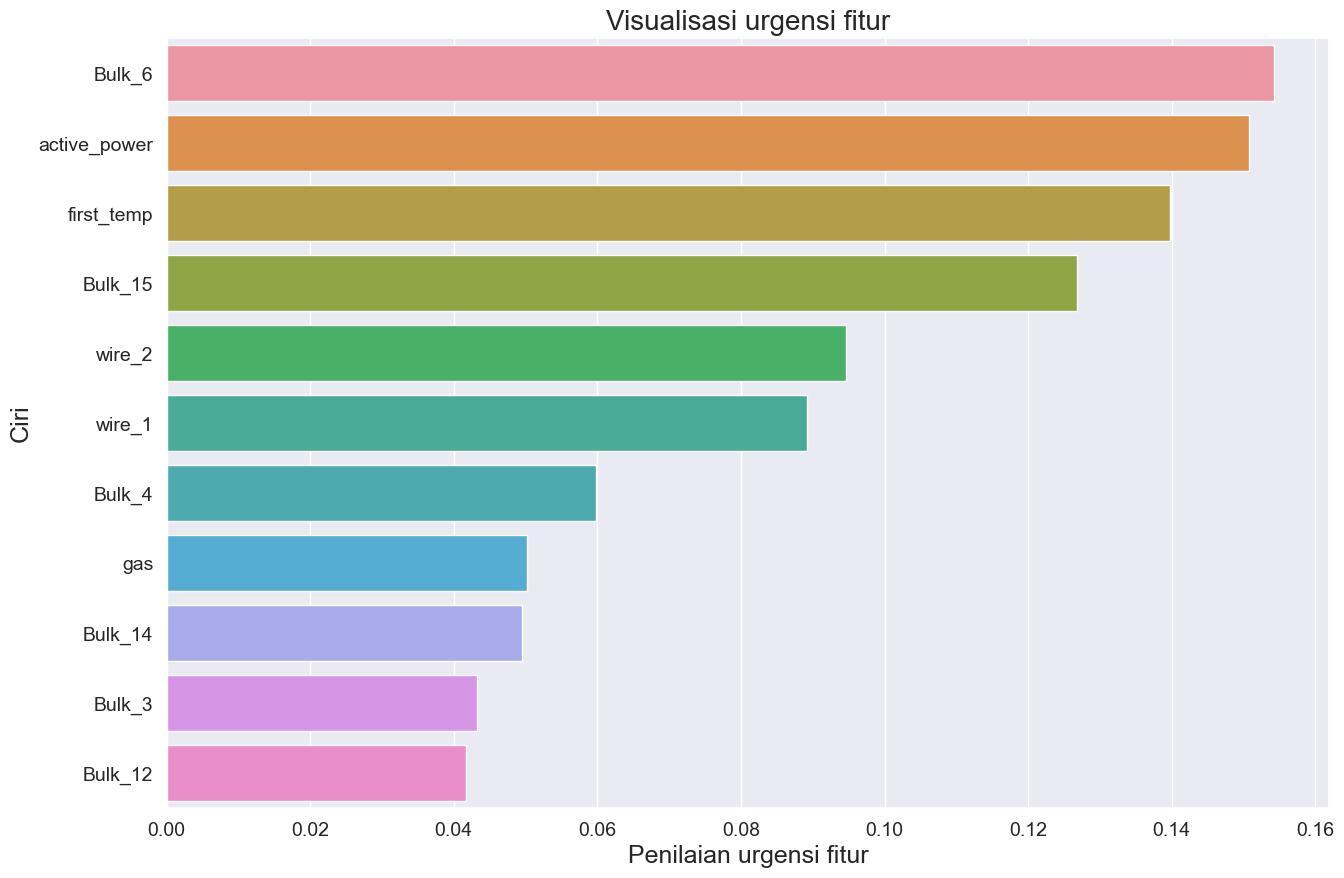

In [69]:
# membuat grafik dengan urgensi fitur
chart_feature_imp(result_xgb.best_estimator_,X_train)

[Kembali ke Daftar Isi](#back)

# Temuan <a name='end'></a>

Setiap poin dari perencanaan project telah dikerjakan:
- analisis lengkap dari data yang diperoleh telah dilakukan
- semua distribusi yang diperlukan telah diplot
- waktu pemanasan dan daya penuh telah ditemukan
- fitur diperiksa untuk kolinearitas (fitur tersebut dihilangkan)
- fitur "waktu" tidak digunakan dalam pelatihan
- Material yang jarang digunakan telah dihilangkan dari fitur pembelajaran
- Menggunakan hasil pengukuran suhu, suhu awal diekstraksi yang digunakan sebagai fitur serta suhu keluaran yang juga digunakan sebagai fitur target saat melatih model

Beberapa model telah dilatih pada set pengujian yang menunjukkan hasil sebagai berikut:

```
+---------------------------+---------+
| Nama Model                |     MAE |
+===========================+=========+
| Linear Regression(scaler) | 6.28753 |
+---------------------------+---------+
| Linear Regression         | 6.28753 |
+---------------------------+---------+
| Decision Tree             | 7.12398 |
+---------------------------+---------+
| Random Forest             | 6.14975 |
+---------------------------+---------+
| XGBoost                   | 6.09714 |
+---------------------------+---------+

```
  
Untuk semua model, parameter dipilih dengan menggunakan GridSearchCV. RANDOM_STATE ditetapkan ke "281122".
MAE digunakan sebagai metrik untuk memvalidasi model.

Data dibagi menjadi dua sampel:
- pelatihan
- pengujian

Set pengujian digunakan untuk model terbaik yang menunjukkan MAE sebesar 6,09.
Analisis fitur juga dilakukan menurut urgensi relatif terhadap fitur target untuk model terbaik.
Fitur yang paling penting adalah "Bulk_15". Terdapat kemungkinan penambahan material ini sangat memengaruhi suhu. Selain itu, tempat kedua dan ketiga ditempati oleh daya aktif / active power dan suhu pertama di mana hal ini sudah sewajarnya.

[Kembali ke Daftar Isi](#back)

# Ikhtisar Project <a name='summary'></a>

**Tugas yang perlu diselesaikan:**

Dalam proyek ini, perlu dikembangkan model prediktif untuk suhu lelehan / molten logam paduan yang akan membantu bisnis dalam mengelola biaya-biaya.

Sebelum keputusan proyek dibuat, akan lebih baik bila rencana terperinci telah disusun.

**Rencana Project**

1) Untuk membangun model yang memprediksi suhu baja, diperlukan:

    - Persiapan data yang lengkap:
    - Analisis Data Eksploratori
    - Proses missing memahami jenisnya dan metode pembentukan 'missing'
    - Menghitung parameter tambahan (daya penuh, waktu sejak pemanasan dimulai, dll.)
    - Diupayakan memeriksa tanda multikolinearitas (menghapus yang berkorelasi satu sama lain dengan nilai lebih besar dari 0,7)
    - Membuat grafik dan distribusi untuk visualisasi data dan penentuan outlier statistik
    - Menentukan frekuensi penggunaan material untuk paduan / alloying. Memotong yang jarang digunakan
    - Menghapus batch baja yang tidak memiliki fitur target (suhu outlet)
    - Menentukan parameter yang diperlukan untuk model pelatihan dan membentuk tabel fitur.

2) Melatih model machine learning:

    - Regresi linier
    - Regresi linier dengan penskalaan fitur
    - Pohon keputusan (regresi)
    - Hutan acak (regresi)
    - XGBoost

Untuk semua model direncanakan menggunakan pemilihan parameter otomatis menggunakan GridSearchCV. RANDOM_STATE ditetapkan ke "281122". MAE digunakan sebagai metrik untuk memvalidasi model.
Data dibagi menjadi dua sampel:
- pelatihan
- pengujian

Set pengujian digunakan untuk model terbaik. Pemeringkatan fitur menurut kepentingannya relatif terhadap fitur target untuk model terbaik juga merupakan peristiwa penting.



Hal yang telah dilakukan:

Pada tahap pemrosesan data, kita harus menghadapi fenomena yang biasa terjadi pada kumpulan data / dataset :
- outlier statistik
- nilai yang tidak ditentukan

1) Tabel pertama memiliki 4 karakteristik, tidak termasuk nomor lot. Kumpulan data tanpa celah / gap.

- Awal pemanasan arc
- Akhir pemanasan arc
- Daya aktif
- Daya reaktif

    Nama fitur yang telah perlu dan telah diubah:
- arc_heat
- end_arc_heat
- active_power
- reactive_power

    Distribusi daya telah dibangun. Daya total dihitung beserta waktu pemanasan oleh arc dalam hitungan detik. Pada tanda dengan daya reaktif, terdapat nilai negatif. Beberapa artikel dipelajari yang menjelaskan bahwa daya reaktif dapat menjadi negatif tetapi nilai ini adalah satu-satunya pada batch 2116. Diputuskan untuk membuat grafik daya aktif dari daya reaktif dan menggunakannya untuk mengganti nilai melalui ketergantungan logaritmik. Matriks korelasi juga dibuat yang menunjukkan bahwa semua tanda memiliki hubungan yang tinggi. Kemudian hanya tinggal satu yang tersisa.

2) Yang kedua dan ketiga adalah kumpulan data dengan aditif dan kawat paduan / alloying wire. Lebih lanjut dalam ikhtisar ini, kumpulan data ini akan disebut sebagai satu, karena struktur yang sama dan penggunaan metode pemrosesan yang sama.
Ada banyak celah / gap pada kumpulan data / dataset ini. Diasumsikan bahwa celah di dalamnya berarti bahwa aditif atau kawat tidak digunakan dalam batch ini pada titik tertentu sehingga celah tersebut kemudian diganti dengan nol. Sebuah fungsi juga ditulis untuk membuat peringkat bahan paduan berdasarkan frekuensi penggunaan. Ternyata hanya 6 aditif yang digunakan untuk lebih dari 10% batch dan 2 kawat untuk persentase yang sama. Hasilnya, hanya material-material berikut yang akan dimasukkan ke dalam model, yakni:
- Bulk 6
- Bulk 4
- Bulk 3
- Bulk 15
- Bulk 12
- Bulk 14
- Wire 1
- Wire 2.
Matriks korelasi telah dibangun. Multikolinearitas tidak ditemukan.

3) Kumpulan data berikutnya dengan suhu. Mediannya adalah 1591. Nilai minimum dan maksimumnya masing-masing adalah 1191 dan 1705. Dengan bantuan panduan metalurgi ditemukan bahwa suhu untuk melelehkan baja berkisar antara 1300 dan 1600, tergantung pada mutunya. Ada sekitar seribu nilai di luar batas direktori. Semua nilai di bawah 1300 derajat diganti dengan median, tetapi di atas 1600 dibiarkan, karena deviasi ke atas sangat mungkin terjadi. Hal ini juga perlu didiskusikan dengan customer. Distribusi suhu juga diplot, dalam kondisi yang normal.

4) Untuk kumpulan data dengan gas, distribusi dibangun. Normal. Tidak ditemukan outlier. Tidak ada yang lolos.

5) Kumpulan data yang berisi waktu tidak diproses karena tidak akan digunakan dalam model. Dalam kasus ini, masalah deret waktu tidak terpecahkan.

- Pada tahap akhir persiapan data, tabel yang diproses digabungkan
- Menghapus semua pihak yang tidak memiliki fitur target
- Menghapus semua fitur dengan multikolinieritas (daya aktif dihemat)
- Fitur dengan parameter "waktu" telah dihapus.


Pada tahap berikutnya, model yang dijelaskan dalam rencana project tersebut dipilih dan dilatih. Pada tahap pemilihan algoritma ini, XGBoost menunjukkan kinerja paling positif dengan metrik MAE = 6,09.
Data tentang metrik algoritma lainnya diberikan dalam tabel di bawah ini:

```
+---------------------------+---------+
| Nama Model                |     MAE |
+===========================+=========+
| Linear Regression(scaler) | 6.28753 |
+---------------------------+---------+
| Linear Regression         | 6.28753 |
+---------------------------+---------+
| Decision Tree             | 7.12398 |
+---------------------------+---------+
| Random Forest             | 6.14975 |
+---------------------------+---------+
| XGBoost                   | 6.09714 |
+---------------------------+---------+
```

Set pengujian digunakan untuk model terbaik;
Analisis fitur juga dilakukan menurut kepentingannya relatif terhadap fitur target untuk model terbaik. Fitur yang paling penting adalah "Bulk_15".  Terdapat kemungkinan penambahan material ini sangat memengaruhi suhu. Selain itu, tempat kedua dan ketiga ditempati oleh daya aktif dan suhu pertama di mana hal ini sudah sewajarnya.

[Kembali ke Daftar Isi](#back)